<p align="center"><h1> Задание #2 </h1></p>
<h2>Binary Classification Task</h2>
<hr/>
<h4><b><i>Цель задания:</i></b></h4> <i><ul>
 <li>Предсказать значения целевой переменной "Target" </li>
 <li>Определить выбор метода прогнозирования. </li>
 <li>Привести оценки точности и качества модели</li>
 <li>Построить ROC-кривую</li>
 <li>Определить три наиболее важных предиктора</li>
    </i>
<h4><b><i>Входные данные:</i></b></h4> <i> <ul><li>Тренировочные данные представлены в файле "Training.csv"</li> <li>Валидационные данные представлены в файле "Validate.csv".</li></i>
    <h4><b><i>Используемые модели:</i></b></h4><i>LogisticRegression, LGBMClassifier, RandomForestClassifier, CatBoostClassifier</i>
<h4><b><i>Метрики качества модели:</i></b></h4><i>roc_auc, recall, precision, logloss</i>
<h4><b><i>Итоги:</i></b></h4>
<i>Предсказаные значения по валидационной выборке находятся в файле -  "pred_class.csv".</br>
   Для финальной модели использовалась Логистическая регрессия с настройкой гиперпараметров. Которая на тестовой выборке показала результат по roc_auc - 0.776. </br>
   Также в качестве сравнения использовались Случайный лес и модели бустинга.</br>
   Наиболее важными предикторами оказались - P23, P22, P12</i>
<hr/>

## Work plan

[1.Импорт библиотек и данных](#1)

[2.Предварительная обработка данных](#2_1)

[3.Предварительный анализ данных](#3)

[4.Построение моделей - Baseline](#4)

[5. Анализ важности предикторов](#5)

[6. Подбор гиперпараметров](#6)

[7. Предсказание на валидационной выборке](#7)

<a id='1'><h2>1. Импорт библиотек и данных</h2></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # графики в svg выглядят более четкими
from pylab import rcParams # увеличим дефолтный размер графиков
rcParams["figure.figsize"] = 8, 5

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,KFold
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score,\
precision_score, f1_score, log_loss, roc_auc_score, auc, roc_curve, confusion_matrix

import optuna

import warnings
warnings.filterwarnings('ignore')
RAND=8
np.random.seed(RAND)

In [2]:
ls

Task2.pptx    Training.csv  Validate.csv  main.ipynb


In [3]:
trainset = pd.read_csv('Training.csv',on_bad_lines='skip', sep=";", index_col='ID',decimal=',')
valset = pd.read_csv('Validate.csv',on_bad_lines='skip', sep=";", index_col='ID',decimal=',')

In [4]:
trainset.shape

(10000, 32)

In [5]:
valset.shape

(20000, 32)

<a id='2_1'><h2>2. Обработка данных</h2></a>

In [6]:
trainset.head()

,Target,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
ID,,,,,,,,,,,,,,,,,,,,,
283,1,0.0,NaN,NaN,10,0,1.02,1.02,1.55,1.15,...,831.68,783.82,171.33,818.15,0.63,0.13,0.00,6.42,0.97,6.42
342,0,0.0,30.00,6.80,0,0,1.00,1.65,1.15,0.41,...,195.14,168.30,81.00,NaN,6.32,0.27,0.33,NaN,1.61,3.45
631,0,0.0,30.00,9.60,0,0,1.00,0.84,NaN,0.00,...,226.11,207.42,110.00,184.49,2.26,0.00,0.07,NaN,0.75,8.08
1165,0,0.0,30.33,15.33,0,0,0.99,0.88,NaN,2.68,...,567.54,441.53,194.00,625.32,2.74,0.13,0.40,13.50,0.98,13.50
1469,0,0.0,28.00,7.54,0,0,0.93,1.21,0.60,0.00,...,154.81,86.64,71.67,53.45,0.91,0.47,0.40,NaN,0.40,3.45


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 283 to 12858142
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  10000 non-null  int64  
 1   P1      10000 non-null  float64
 2   P2      8492 non-null   float64
 3   P3      8523 non-null   float64
 4   P4      10000 non-null  int64  
 5   P5      10000 non-null  int64  
 6   P6      10000 non-null  float64
 7   P7      10000 non-null  float64
 8   P8      8482 non-null   float64
 9   P9      10000 non-null  float64
 10  P10     10000 non-null  float64
 11  P11     10000 non-null  float64
 12  P12     10000 non-null  float64
 13  P13     10000 non-null  float64
 14  P14     10000 non-null  float64
 15  P15     10000 non-null  float64
 16  P16     8475 non-null   float64
 17  P17     10000 non-null  float64
 18  P18     10000 non-null  float64
 19  P19     10000 non-null  float64
 20  P20     10000 non-null  float64
 21  P21     10000 non-null  float6

In [8]:
valset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 127 to 8850463
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  0 non-null      float64
 1   P1      20000 non-null  float64
 2   P2      17032 non-null  float64
 3   P3      17021 non-null  float64
 4   P4      20000 non-null  float64
 5   P5      20000 non-null  float64
 6   P6      20000 non-null  float64
 7   P7      20000 non-null  float64
 8   P8      16985 non-null  float64
 9   P9      20000 non-null  float64
 10  P10     20000 non-null  float64
 11  P11     20000 non-null  float64
 12  P12     20000 non-null  float64
 13  P13     20000 non-null  float64
 14  P14     20000 non-null  float64
 15  P15     20000 non-null  float64
 16  P16     16997 non-null  float64
 17  P17     20000 non-null  float64
 18  P18     20000 non-null  float64
 19  P19     20000 non-null  float64
 20  P20     20000 non-null  float64
 21  P21     20000 non-null  float64

In [9]:
# приведем все предикторы к единому типу - float
col_int = trainset.drop('Target', axis=1)\
        .select_dtypes(include = ['int'])\
        .columns
trainset[col_int] = trainset[col_int].astype('float')

In [10]:
trainset.select_dtypes(include = ['int']).columns

Index(['Target'], dtype='object')

### Заполнение пропусков

In [11]:
trainset.isna().sum()[trainset.isna().sum()>0]

P2     1508
P3     1477
P8     1518
P16    1525
P25    1504
P29    1533
dtype: int64

In [12]:
valset.isna().sum()[trainset.isna().sum()>0]

P2     2968
P3     2979
P8     3015
P16    3003
P25    3021
P29    3013
dtype: int64

In [13]:
# отфильтруем только те колонки, где есть пропуски
na_cols = trainset.isna().sum()[trainset.isna().sum()>0].index.to_list()

In [14]:
trainset[na_cols].describe()

,P2,P3,P8,P16,P25,P29
count,8492.000000,8523.000000,8482.000000,8475.000000,8496.000000,8467.000000
mean,24.971760,14.497475,0.875068,3.033444,268.877174,9.049746
std,7.536554,10.703979,0.524675,2.145316,355.736549,5.529276
min,1.000000,0.720000,0.000000,0.200000,0.000000,0.000000
25%,22.330000,8.005000,0.590000,0.870000,47.190000,4.320000
50%,28.670000,12.530000,0.880000,2.870000,146.880000,9.120000
75%,30.330000,18.525000,1.130000,5.000000,346.655000,9.920000
max,30.330000,287.940000,3.000000,8.230000,5339.970000,96.290000


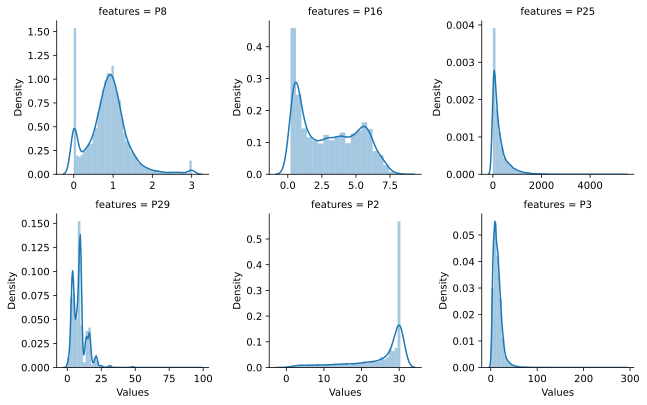

In [15]:
numeric_features = trainset[na_cols]
numeric_features = numeric_features.stack().reset_index().rename(columns = {'level_1':'features', 0:'Values'})
g = sns.FacetGrid(numeric_features,col = 'features', col_wrap = 3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'Values')

plt.subplots_adjust(top=0.9)

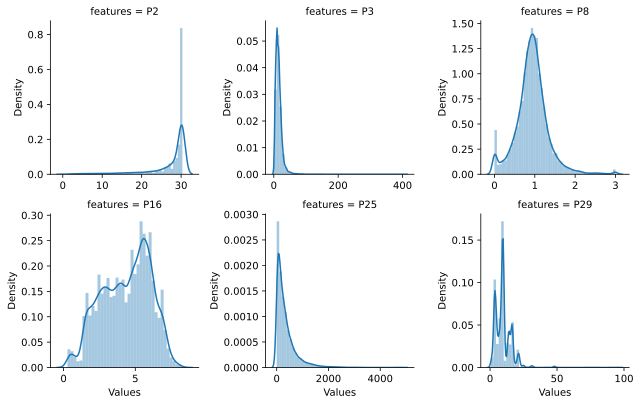

In [16]:
numeric_features = valset[na_cols]
numeric_features = numeric_features.stack().reset_index().rename(columns = {'level_1':'features', 0:'Values'})
g = sns.FacetGrid(numeric_features,col = 'features', col_wrap = 3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'Values')

plt.subplots_adjust(top=0.9)

#### Распределения одинаковые в обоих датасетах. Однако сами распределения далеки от нормального распределения. Заполним пропущенные значения модой

In [17]:
for i in na_cols:
    trainset[i].fillna(trainset[i].mode()[0], inplace=True)
    valset[i].fillna(valset[i].mode()[0], inplace=True)

In [18]:
assert trainset.isna().sum().sum() == 0
assert valset.drop('Target', axis=1).isna().sum().sum() == 0 

<a id='3'><h2>3. Предварительный анализ данных</h2></a>

<h3>3.1 Рассмотрим распределение целевой переменной и ее взаимосвязь с признаками</h3>

In [19]:
round(trainset['Target'].value_counts(normalize=True),2)

1    0.5
0    0.5
Name: Target, dtype: float64

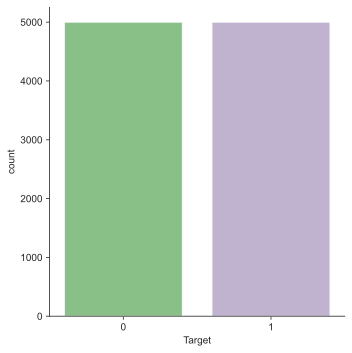

In [20]:
sns.set_palette('Accent')
sns.set_style('ticks')
sns.catplot(kind = 'count', data = trainset, x = 'Target');

#### Посмотрим на корреляцию предикторов с целевой переменной и выделим основные признаки

In [21]:
trainset.corr(method='pearson').iloc[0,1:].sort_values(key = lambda x: abs(x), ascending=False)

P23   -0.261993
P16   -0.261741
P2    -0.251839
P10   -0.247395
P22   -0.236605
P24   -0.217153
P4     0.207070
P17   -0.207068
P25   -0.183514
P11   -0.158195
P6    -0.150803
P29   -0.136676
P31   -0.121379
P28    0.116998
P27    0.109816
P8    -0.101933
P26   -0.088349
P30   -0.079326
P3    -0.057346
P15   -0.047444
P1     0.040691
P18    0.039944
P12   -0.033965
P5     0.018515
P13   -0.017436
P21    0.016794
P14    0.011657
P20    0.011056
P9     0.004477
P7    -0.003024
P19   -0.000660
Name: Target, dtype: float64

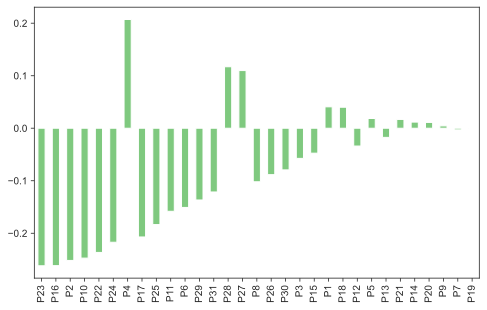

In [22]:
trainset.corr().iloc[0,1:].sort_values(key = lambda x: abs(x), ascending=False).plot.bar();

### Мы видим, что самая высокая корреляция у предикторов  - P23, P16, P2, P10, P22

<h3>3.2 Обработаем данные и подготовим к обучению</h3>

In [23]:
# нормализуем данные при помощи StandardScaler
cols = trainset.drop('Target',axis=1).columns
scaler = StandardScaler()
trainset[cols] = scaler.fit_transform(trainset[cols])

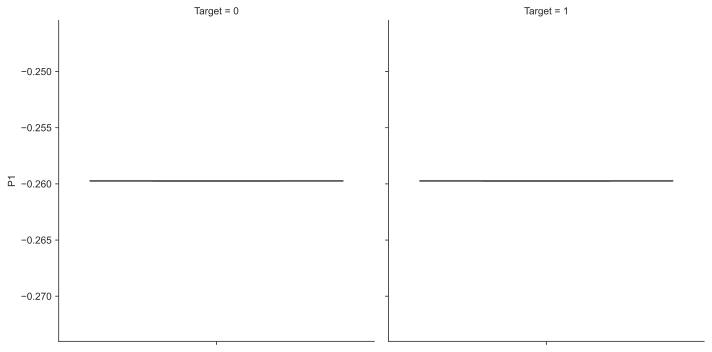

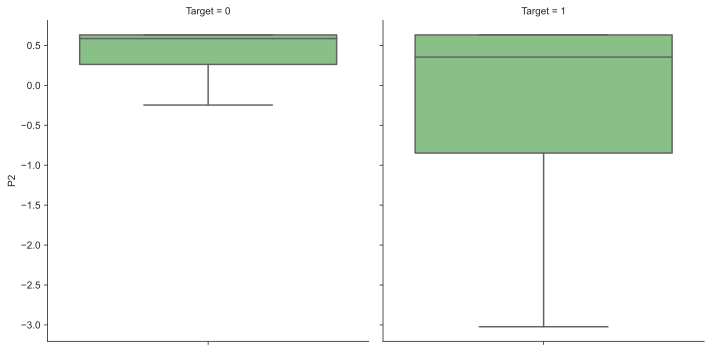

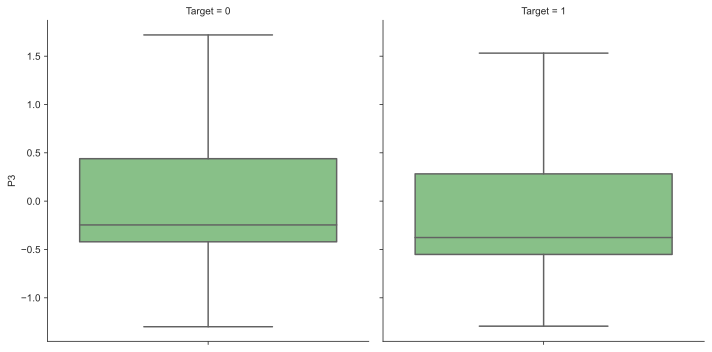

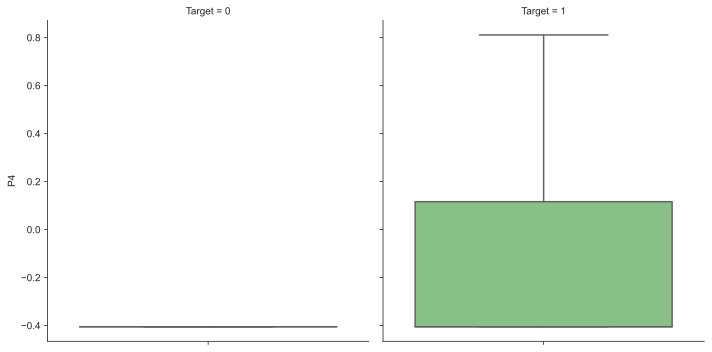

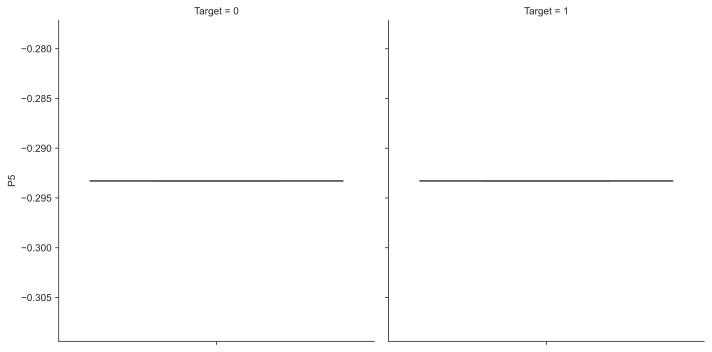

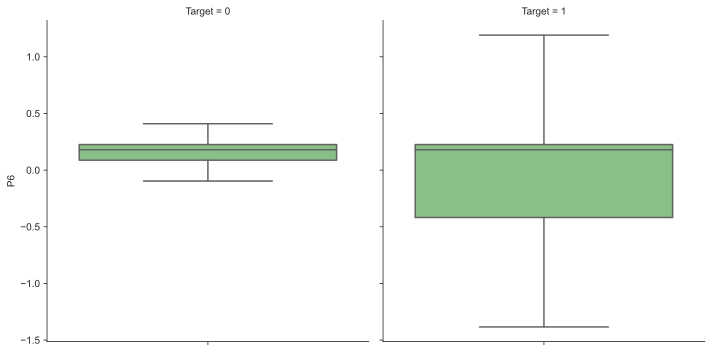

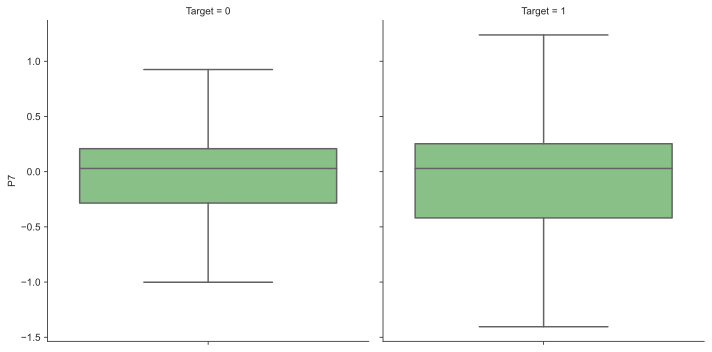

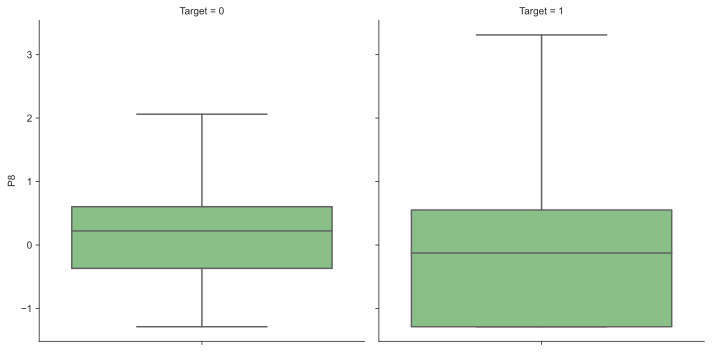

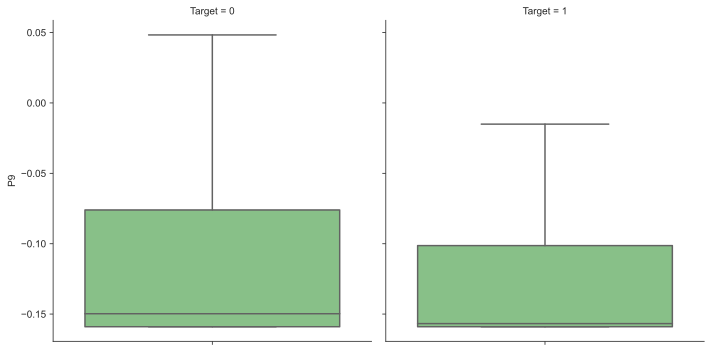

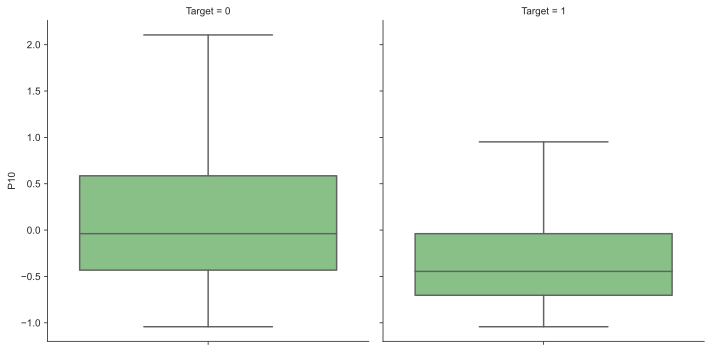

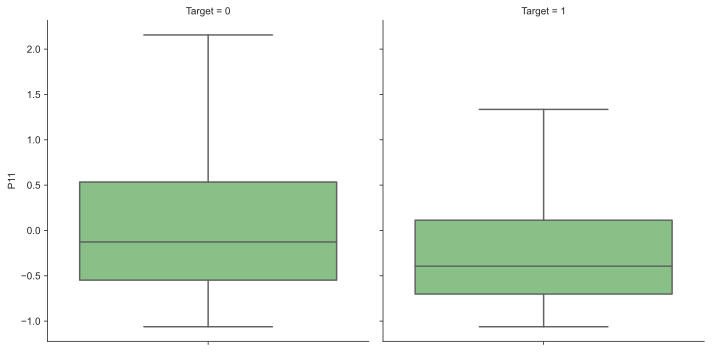

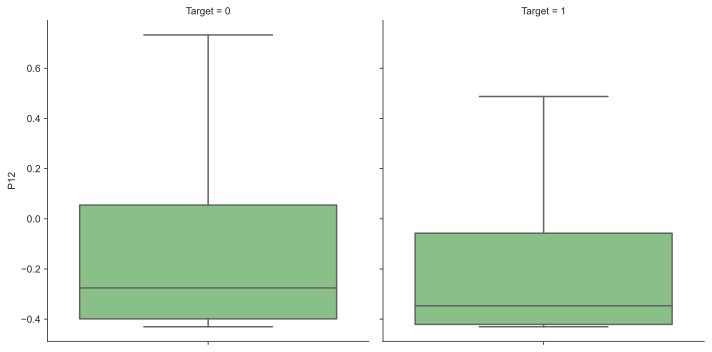

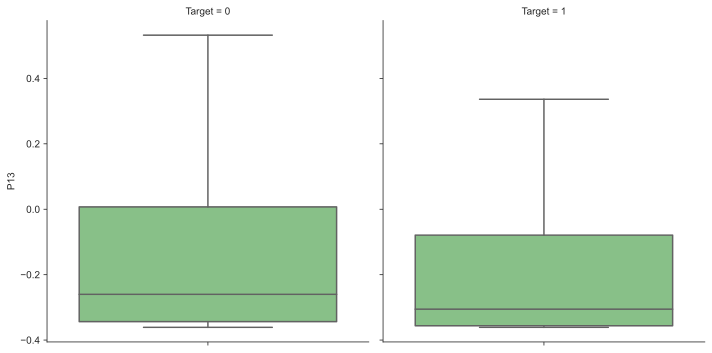

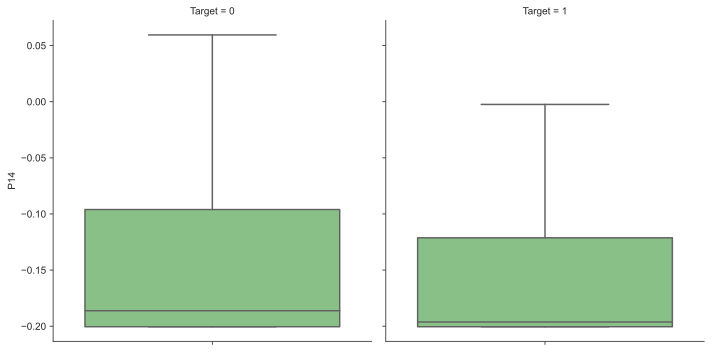

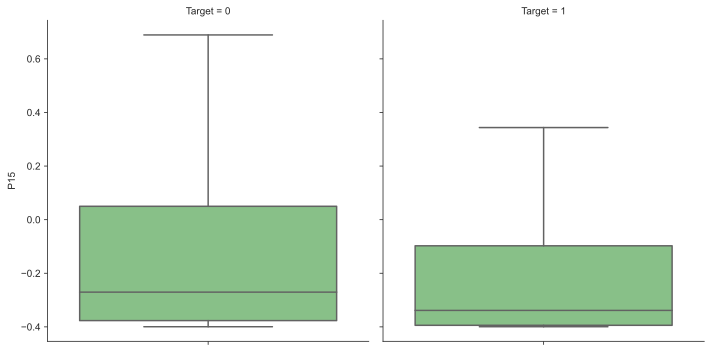

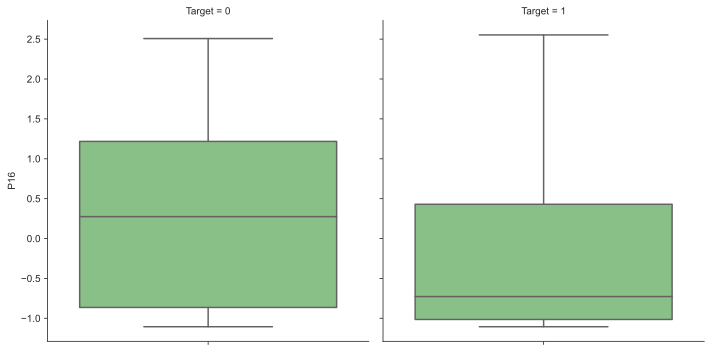

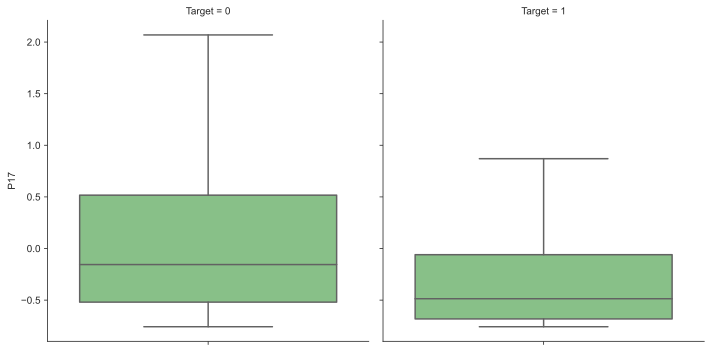

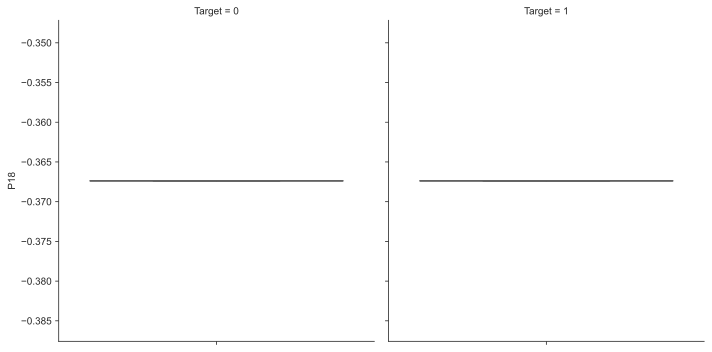

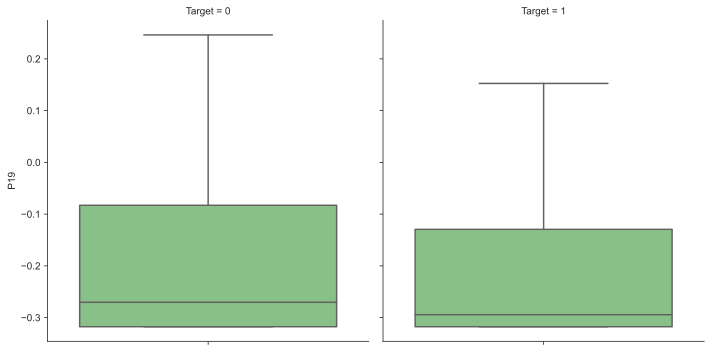

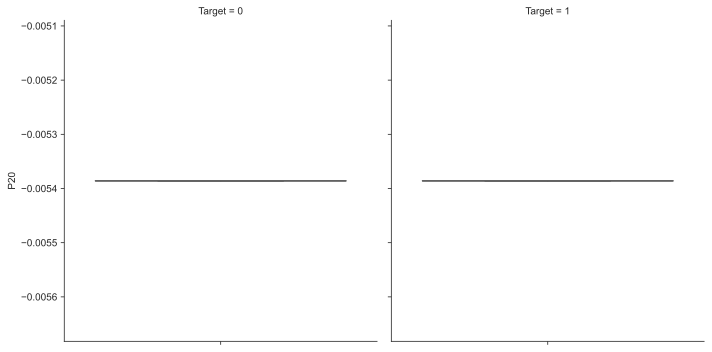

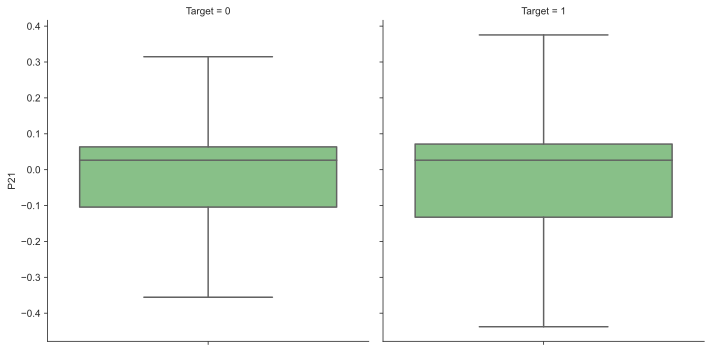

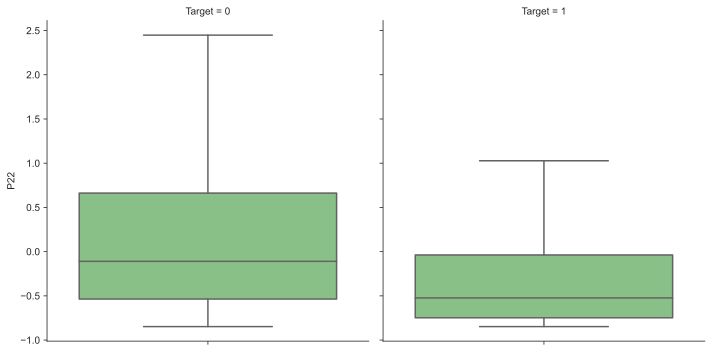

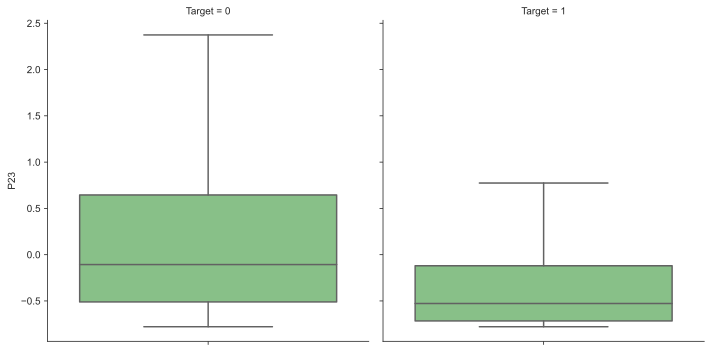

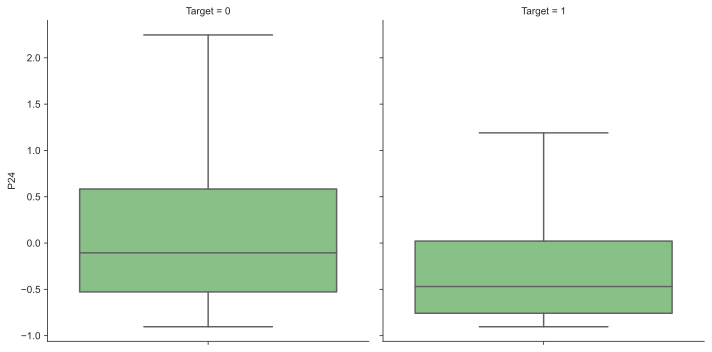

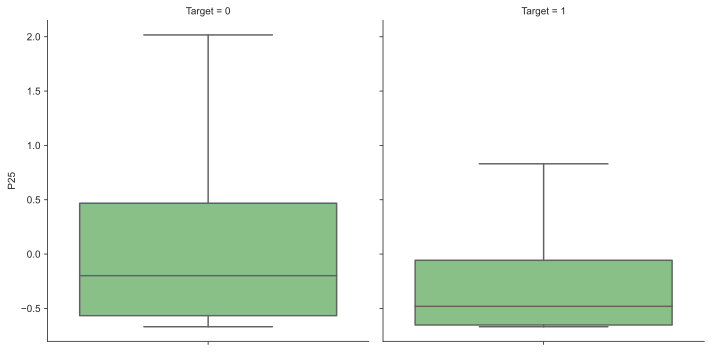

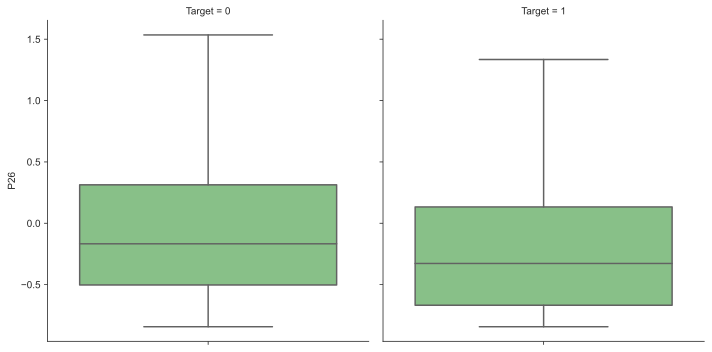

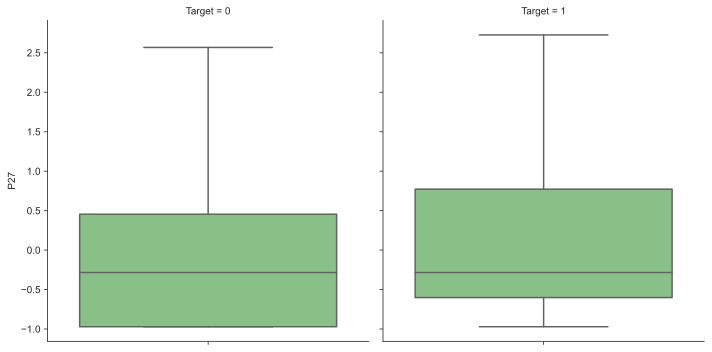

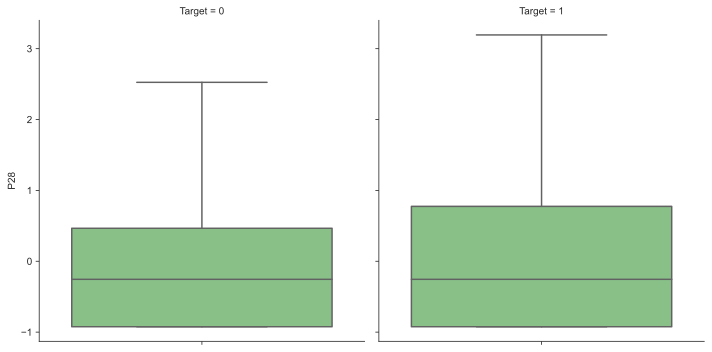

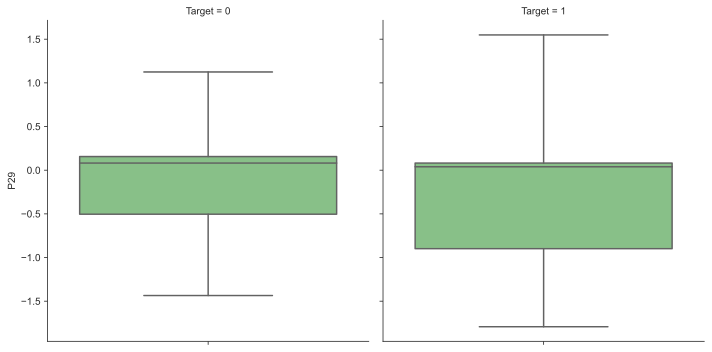

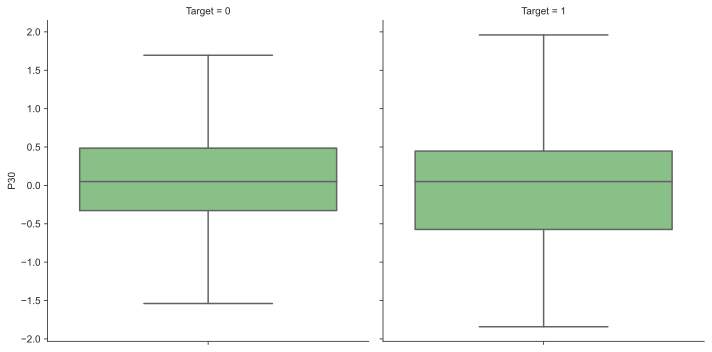

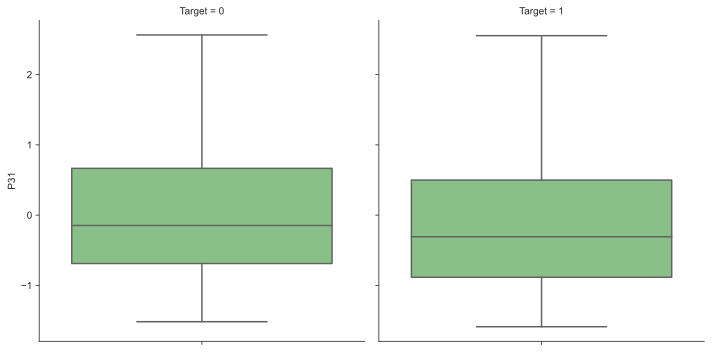

In [24]:
for i in trainset.drop('Target', axis=1).columns:
    sns.catplot(kind = 'box', data = trainset, y = i, col = 'Target', sym ='')

#### Разделим данные на тренировочные и тестовые. Размер тестовой выборки - 20%

In [25]:
X = trainset.drop('Target', axis=1)
y = trainset.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND)

In [26]:
X_train.shape, X_test.shape

((8000, 31), (2000, 31))

In [27]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.50175
 1    0.49825
 Name: Target, dtype: float64,
 1    0.507
 0    0.493
 Name: Target, dtype: float64)

<a id='4'><h2>4. Построение моделей</a></h2>

### Поскольку у нас задача бинарной классицикации, то рассмотрим в качестве Baseline Логистическую регрессию, Случайный лес и варианты бустингов (LGBM, Catboost)
### Сравним модели на кроссвалидации cv=5 и метрике roc_auc

In [28]:
# LogisticRegression
LogisticRegression_model = LogisticRegression(random_state=RAND)
LogisticRegression_score = cross_val_score(LogisticRegression_model, X_train, y_train,scoring='roc_auc', cv=5)
print('LogisticRegression_score: ', LogisticRegression_score.mean())

LogisticRegression_score:  0.7596469892544027


In [29]:
# LGBMClassifier
ligthgbmc_model = LGBMClassifier(random_state=RAND)
ligthgbmc_score = cross_val_score(ligthgbmc_model, X_train, y_train,scoring='roc_auc', cv=5)
print('ligthgbmc_score: ', ligthgbmc_score.mean())

ligthgbmc_score:  0.7442817791137892


In [30]:
# CatBoostClassifier
cbc_model = CatBoostClassifier(random_state=RAND, verbose=False)
cbc_score = cross_val_score(cbc_model, X_train, y_train, cv=5,scoring='roc_auc')
print('cbc_score: ', cbc_score.mean())

cbc_score:  0.7532153302862115


In [31]:
#RandomForestClassifier
for_model = RandomForestClassifier(random_state=RAND, max_depth=5)
for_score = cross_val_score(cbc_model, X_train, y_train, cv=5,scoring='roc_auc')
print('for_score: ', for_score.mean())

for_score:  0.7532153302862115


#### Видим, что на кроссвалидации лучше всех показала Логистическая регрессия
#### Создадим отдельный датафрейм, куда будем записывать результаты моделей

In [32]:
metrics = pd.DataFrame(
    index = ['roc-auc', 'recall','precision', 'f1','logloss']) 

In [33]:
def fit_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]
    result = [roc_auc_score(y_test, y_score),
                          recall_score(y_test, y_pred),
                          precision_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
    return result

In [34]:
metrics['Baseline_LR'] = fit_model(LogisticRegression(random_state=RAND))
metrics['Baseline_LGBM'] = fit_model(LGBMClassifier(random_state=RAND))
metrics['Baseline_Catboost'] = fit_model(CatBoostClassifier(random_state=RAND, verbose=False))
metrics['Baseline_Forest'] = fit_model(RandomForestClassifier(random_state=RAND, max_depth=3))

In [35]:
metrics

,Baseline_LR,Baseline_LGBM,Baseline_Catboost,Baseline_Forest
roc-auc,0.768075,0.765109,0.771514,0.732019
recall,0.705128,0.713018,0.712032,0.629191
precision,0.703048,0.701942,0.704390,0.683816
f1,0.704087,0.707436,0.708190,0.655367
logloss,10.379023,10.327217,10.275407,11.587877


### Построим ROC-кривую и confusion matrix

In [36]:
lr_base = LogisticRegression(random_state=RAND)
lr_base.fit(X_train, y_train)

y_pred = lr_base.predict(X_test)
y_score = lr_base.predict_proba(X_test)[:,1]

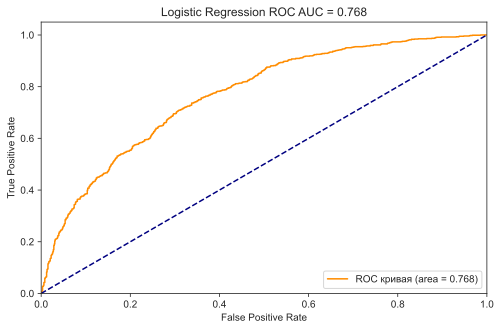

In [37]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")

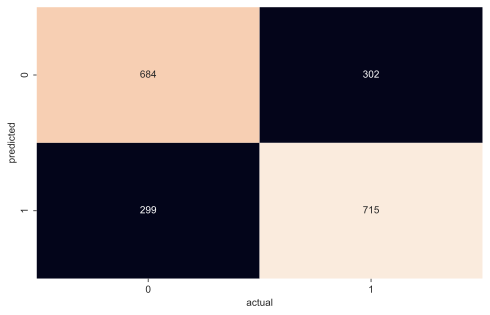

In [38]:
matrix = pd.crosstab(y_test, y_pred, rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);

<a id='5'><h2>5. Анализ важности признаков</h2></a>

In [39]:
model_log = LogisticRegression(random_state=RAND)
model_log.fit(X_train, y_train)

LogisticRegression(random_state=8)

In [40]:
model_log.coef_

array([[ 0.07744716, -0.27802669,  0.12535617,  0.23236219, -0.05318857,
        -0.18251119,  0.08483969, -0.07304458, -0.06070523, -0.33385263,
        -0.06445819, -0.85133947,  0.03845407, -0.41359179, -0.77884731,
        -0.353428  ,  0.01405852,  0.01121893,  0.09967021, -0.03228636,
         0.05336204,  5.15518825, -4.73530829, -0.11536397, -0.01572707,
        -0.08707739,  0.03198959,  0.24566871, -0.05016785, -0.09370426,
        -0.09422367]])

In [41]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X_train.columns
feature_imp['imp'] = model_log.coef_[0]
feature_imp = feature_imp.sort_values('imp', ascending = False)

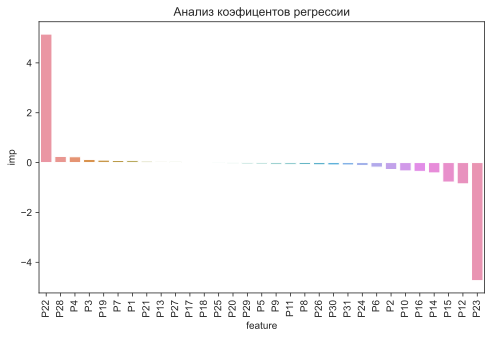

In [42]:
sns.barplot(data = feature_imp, x = 'feature', y = 'imp')
plt.title('Анализ коэфицентов регрессии')
plt.xticks(rotation=90);

In [43]:
feature_imp.sort_values('imp', key=lambda x: abs(x)).head(8)

,feature,imp
17,P18,0.011219
16,P17,0.014059
24,P25,-0.015727
26,P27,0.031990
19,P20,-0.032286
12,P13,0.038454
28,P29,-0.050168
4,P5,-0.053189


In [44]:
del_cols = ['P17','P25','P20','P13','P27','P18','P9','P29']

#### Видим, что наиболее важные признаки - P23, P22, P12, P15, P14
#### Попробуем убрать менее важные признаки, и снова обучить модель

In [45]:
del_cols = ['P17','P25','P20','P13','P27','P18','P9','P29']

In [46]:
# LogisticRegression
LogisticRegression_model = LogisticRegression(random_state=RAND)
LogisticRegression_score = cross_val_score(LogisticRegression_model, 
                                           X_train.drop(del_cols, axis=1), 
                                           y_train,
                                           scoring='roc_auc', cv=5)
print('LogisticRegression_score: ', LogisticRegression_score.mean())

LogisticRegression_score:  0.7609895056237577


#### Результат немного улучшился, поэтому удалим данные признаки из датасетов

In [47]:
X_train = X_train.drop(del_cols, axis=1)
X_test = X_test.drop(del_cols, axis=1)

<a id='6'><h2>6. Подбор гиперпараметров</a></h2> 

In [48]:
parameters_grid = {
    'penalty' : ['l1','l2','elasticnet'],
    'C' : np.linspace(1,1000,5),
    'solver' : ['sag','saga','lbfgs'],
    'l1_ratio' : [0.25,0.5,0.75],
    'max_iter' : np.arange(100,500,100)
}
lr = LogisticRegression(random_state=RAND)
grid_cv = GridSearchCV(lr, parameters_grid, scoring='roc_auc', n_jobs=-1)

In [49]:
%%time
#grid_cv.fit(X_train, y_train)

CPU times: user 12 µs, sys: 7 µs, total: 19 µs
Wall time: 3.81 µs


In [50]:
#grid_cv.best_params_

In [51]:
best_params = {'C': 1000.0,
 'l1_ratio': 0.25,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [52]:
metrics['Grid_LR'] = fit_model(LogisticRegression(**best_params, random_state=RAND))
metrics

,Baseline_LR,Baseline_LGBM,Baseline_Catboost,Baseline_Forest,Grid_LR
roc-auc,0.768075,0.765109,0.771514,0.732019,0.776031
recall,0.705128,0.713018,0.712032,0.629191,0.714004
precision,0.703048,0.701942,0.704390,0.683816,0.708415
f1,0.704087,0.707436,0.708190,0.655367,0.711198
logloss,10.379023,10.327217,10.275407,11.587877,10.154519


#### При помощи подбора гиперпараметров удалось достичь результат в 0.78 по roc-auc
#### Посмотрим еще раз как улучшился результат на графике Roc-кривой

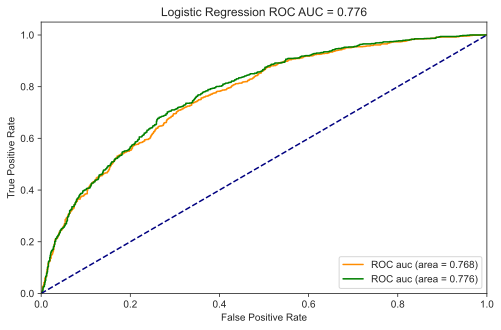

In [53]:
lr_base = LogisticRegression(**best_params, random_state=RAND)
lr_base.fit(X_train, y_train)

y_pred_grid = lr_base.predict(X_test)
y_score_grid = lr_base.predict_proba(X_test)[:,1]
# рассчитываем roc-кривую
fpr_2, tpr_2, treshold_2 = roc_curve(y_test, y_score_grid)
roc_auc_2 = auc(fpr_2, tpr_2)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC auc (area = %0.3f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green',
         label='ROC auc (area = %0.3f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_2)
plt.legend(loc="lower right")

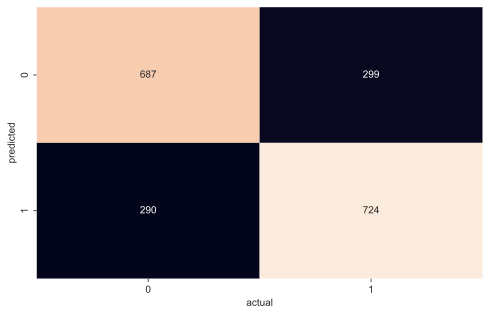

In [54]:
matrix = pd.crosstab(y_test, y_pred_grid, rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);

<a id='7'><h2>7. Предсказание на валидационной выборке</h2></a>

In [55]:
lr_best = LogisticRegression(**best_params, random_state=RAND)

In [56]:
lr_best.fit(X.drop(del_cols, axis=1), y)

LogisticRegression(C=1000.0, l1_ratio=0.25, random_state=8)

In [57]:
y_pred_proba = lr_best.predict_proba(valset.drop(del_cols+['Target'], axis=1))[:,1]

In [58]:
y_pred_class = lr_best.predict(valset.drop(del_cols+['Target'], axis=1))

In [59]:
def to_submission(test_id,predicts, name_file):
    df_submit = pd.DataFrame(data = predicts, columns=['Target'])
    df_submit['ID'] = test_id
    df_submit = df_submit.set_index('ID')
    return df_submit.to_csv(name_file)

In [60]:
#to_submission(valset.index, y_pred_proba, 'pred_proba.csv')
to_submission(valset.index, y_pred_class, 'pred_class.csv')